In [1]:
import os
import pandas as pd
import numpy as np
import random


# import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, auc,roc_curve, precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

pd.options.mode.chained_assignment = None  
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 50) 

## Functions

In [2]:
# 1. Fun
def encode_and_bind(original_dataframe, feature_to_encode):

    """
This fucnction makes One-hot-encoding
    Input: 
    - datatable with deal_kul_id and need features
    - feature for One-hot-encoding
    Output: 
    - datatable with One-hot-encoding features
    
    """
    #1. Make dummies and OHE     
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1).drop(feature_to_encode, axis=1)
    
    return(res)

In [3]:
# 4. Fun
def feature_description(feature, data):
    sns.set(
    font_scale =0.7,
    style      ="whitegrid",
    )
    print('Analyzed feature: ',feature)
    
    if feature in cat_col:
        fig, axes = plt.subplots(2, 1, figsize=(5, 7))

                
        fig1 = sns.countplot(ax=axes[0], data=data, y= feature, orient='h');
        fig1.set(xlabel=None, ylabel = None) 
        axes[0].set_title(f'Distribution of {feature}')
        
        fig2 = sns.barplot(ax=axes[1],y=feature, x="bad_client_target",  data=data, orient='h', errorbar=None) ;
        fig2.set(xlabel=None, ylabel = None) 
        axes[1].set_title(f'Share bad clients in {feature}')
        
        fig.tight_layout()
        
    if feature in num_col:
        fig, axes = plt.subplots(2, 1, figsize=(5, 7))

                
        fig1 = sns.histplot(ax=axes[0], data=data, x= feature);
        fig1.set(xlabel=None, ylabel = None) 
        axes[0].set_title(f'Distribution of {feature}')
        
        fig2 = sns.boxplot(ax=axes[1],x=feature, y="bad_client_target",  data=data, orient='h') ;
        fig2.set(xlabel=None, ylabel = None) 
        axes[1].set_title(f'Distribution of clients type by {feature}')
        
        fig.tight_layout()    

In [4]:
def rfe_selector(X, y, num_feats):
    # 1. Create the object and fit
    model = RandomForestClassifier(random_state=5, 
                               max_depth = 4,
                               max_features = 3,
                               n_estimators = 1000
                              )

    rfe_lr = RFE(estimator=model, 
                 n_features_to_select=num_feats,
                 step=1,
                 verbose=0
    )
    rfe_lr = rfe_lr.fit(X, y)

    # 2. Get Support from the model
    rfe_support = rfe_lr.get_support()

    # 3. Best features from the model
    rfe_feature = X.loc[:, rfe_support].columns.tolist()
#     rfe_lr_feature
    return rfe_support, rfe_feature

## Data preprocessing


### Download data

DataSource:
https://www.kaggle.com/datasets/podsyp/is-this-a-good-customer

In [5]:
# 1. Set path and download data 
data = pd.read_csv('..\\data\\clients.csv', sep=',' )

print('data shape:',data.shape)
data.head()

data shape: (1723, 14)


,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


### Data description

In [6]:
# 1. Look at main info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   month                1723 non-null   int64 
 1   credit_amount        1723 non-null   int64 
 2   credit_term          1723 non-null   int64 
 3   age                  1723 non-null   int64 
 4   sex                  1723 non-null   object
 5   education            1723 non-null   object
 6   product_type         1723 non-null   object
 7   having_children_flg  1723 non-null   int64 
 8   region               1723 non-null   int64 
 9   income               1723 non-null   int64 
 10  family_status        1723 non-null   object
 11  phone_operator       1723 non-null   int64 
 12  is_client            1723 non-null   int64 
 13  bad_client_target    1723 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 188.6+ KB


In [7]:
# 2. Split data on num and categorical var
num_col = [ 'credit_amount', 'credit_term', 'age',
          'income'
          ]
cat_col = [ 'month','sex', 'education', 'product_type', 
           'family_status', 'having_children_flg', 'region', 
           'phone_operator', 'is_client', 'bad_client_target'
          ]
all_columns = data.columns

In [8]:
# 2.1 Description numeric vars
data[num_col].describe()

,credit_amount,credit_term,age,income
count,1723.000000,1723.000000,1723.000000,1723.000000
mean,29264.654672,11.546721,35.911782,32652.350551
std,27926.778301,6.548354,13.120203,20913.193158
min,5000.000000,3.000000,18.000000,1000.000000
25%,13000.000000,6.000000,26.000000,21000.000000
50%,21500.000000,12.000000,32.000000,27000.000000
75%,34000.000000,12.000000,44.000000,38000.000000
max,301000.000000,36.000000,90.000000,401000.000000


In [9]:
# 2.2 Description cat variables
(data[cat_col]
 .astype({'having_children_flg': 'object',
          'region': 'object',
          'phone_operator': 'object',
          'is_client': 'object',
          'bad_client_target': 'object',
          'month': 'object',
         })
 .describe()
)

,month,sex,education,product_type,family_status,having_children_flg,region,phone_operator,is_client,bad_client_target
count,1723,1723,1723,1723,1723,1723,1723,1723,1723,1723
unique,12,2,6,22,3,2,3,5,2,2
top,11,male,Secondary special education,Cell phones,Another,0,2,1,1,0
freq,174,931,836,498,1201,985,1414,666,1042,1527


In [10]:
# 3. Look at NA
data.isna().sum()

month                  0
credit_amount          0
credit_term            0
age                    0
sex                    0
education              0
product_type           0
having_children_flg    0
region                 0
income                 0
family_status          0
phone_operator         0
is_client              0
bad_client_target      0
dtype: int64

In [11]:
# Conclusion:
# 1. No NA values

### Look at dependent variable

In [12]:
# 1. Determine general param
sns.set(
    font_scale =1,
    style      ="whitegrid",
)


Statistics
0    1527
1     196
Name: bad_client_target, dtype: int64
0    0.886245
1    0.113755
Name: bad_client_target, dtype: float64


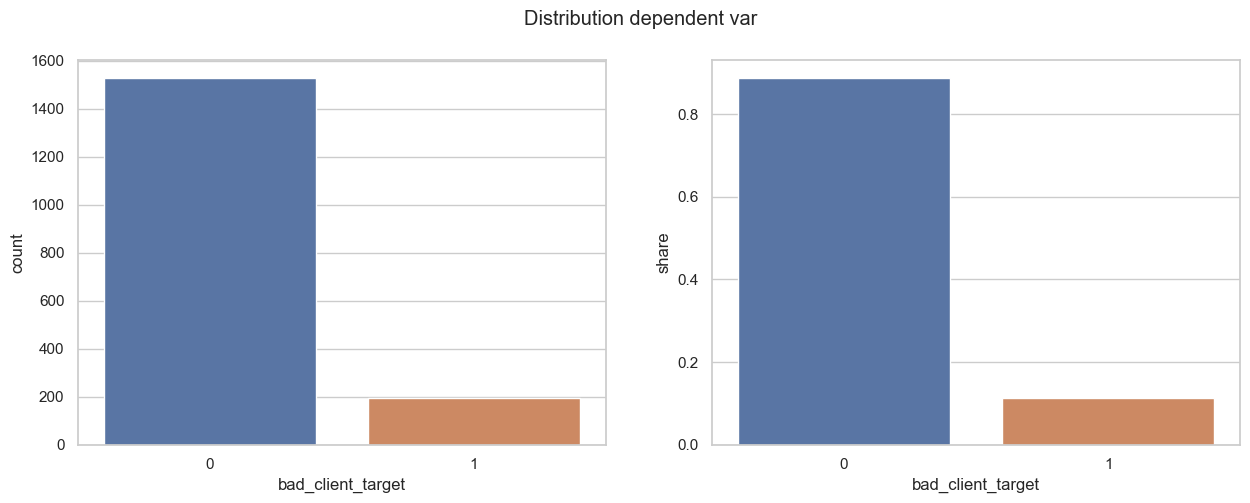

In [13]:
# 1. Make a plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Distribution dependent var')
fig1 = sns.countplot(ax=axes[0], data=data, x='bad_client_target', orient='v');
df_share = pd.DataFrame(data.bad_client_target.value_counts(1)).reset_index()
df_share.columns = ['bad_client_target', 'share']
fig2 =sns.barplot(df_share, x = 'bad_client_target', y = 'share');

print()
print('Statistics')
print(data.bad_client_target.value_counts())
print(data.bad_client_target.value_counts(1))

In [14]:
# What we can do better: Lets make outpit Statistics and plots more beutiful! For example, with plotly

In [15]:
# Conclusion:
# There is an imbalance problem'

### Look at independent variable

Analyzed feature:  month


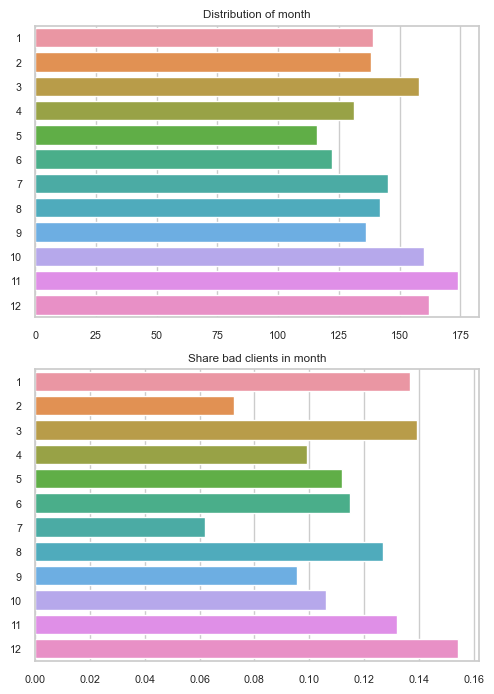

In [16]:
feature = data.columns[0]
feature_description(feature, data)

Analyzed feature:  credit_amount


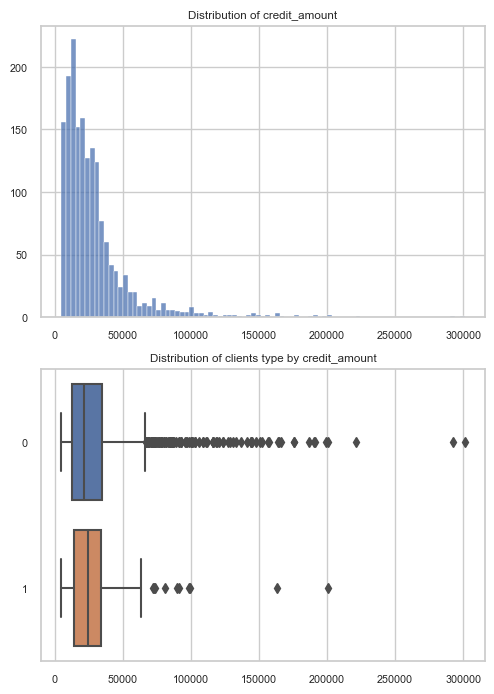

In [17]:
feature = data.columns[1]
feature_description(feature, data)

Analyzed feature:  credit_term


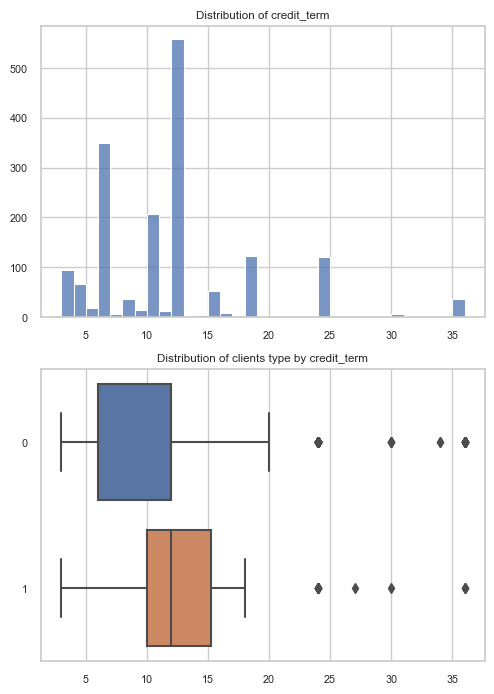

In [18]:
feature = data.columns[2]
feature_description(feature, data)

Analyzed feature:  age


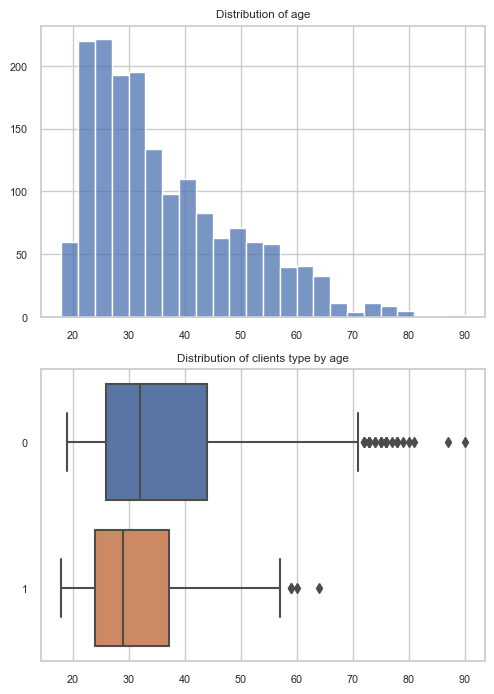

In [19]:
feature = data.columns[3]
feature_description(feature, data)

Analyzed feature:  sex


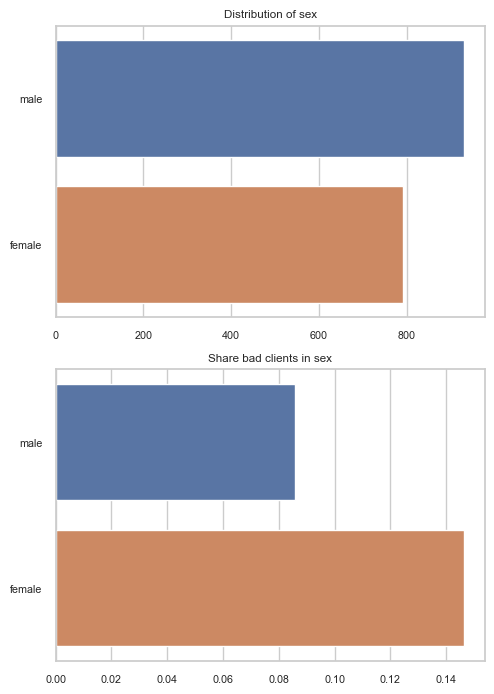

In [20]:
feature = data.columns[4]
feature_description(feature, data)

Analyzed feature:  education


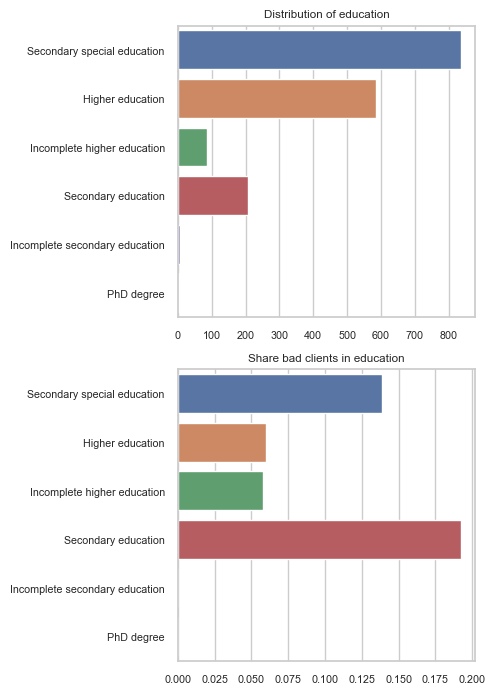

In [21]:
feature = data.columns[5]
feature_description(feature, data)

Analyzed feature:  product_type


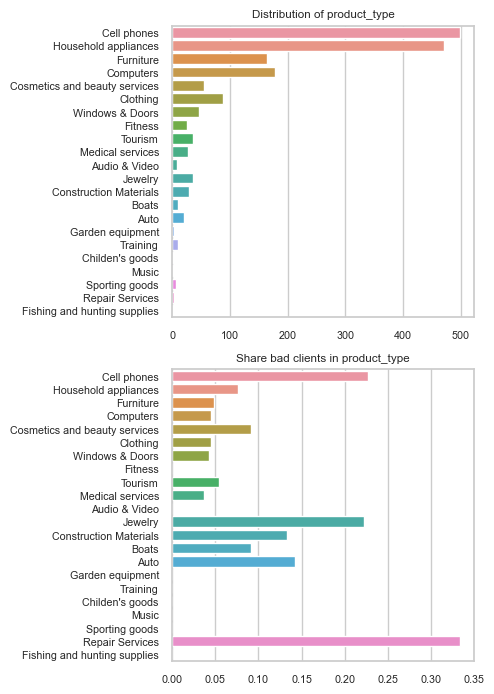

In [22]:
feature = data.columns[6]
feature_description(feature, data)

Analyzed feature:  having_children_flg


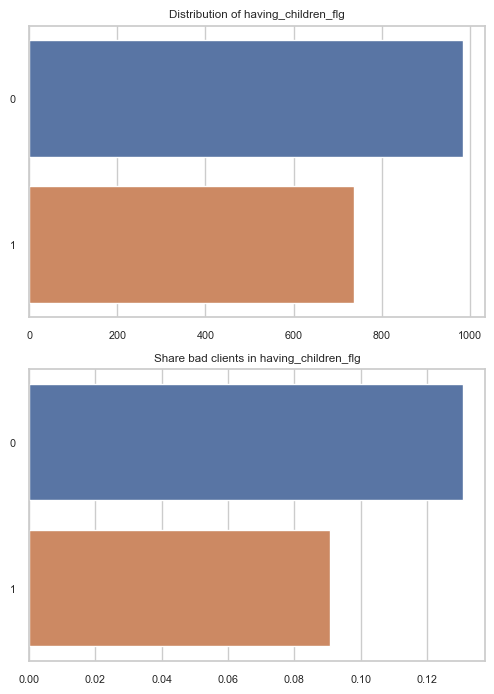

In [23]:
feature = data.columns[7]
feature_description(feature, data)

Analyzed feature:  region


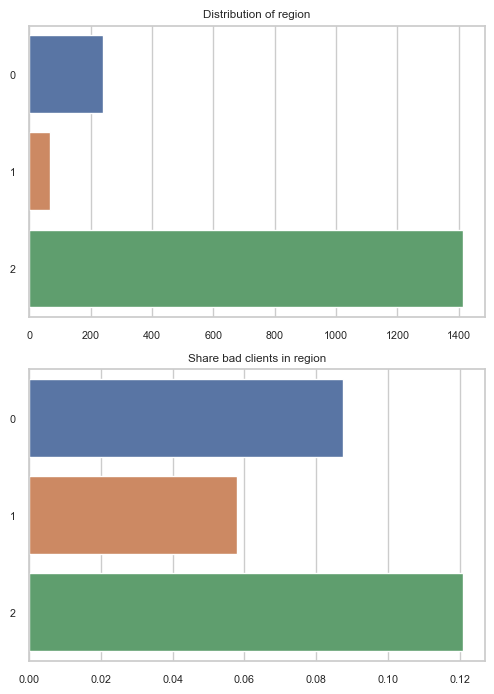

In [24]:
feature = data.columns[8]
feature_description(feature, data)

Analyzed feature:  income


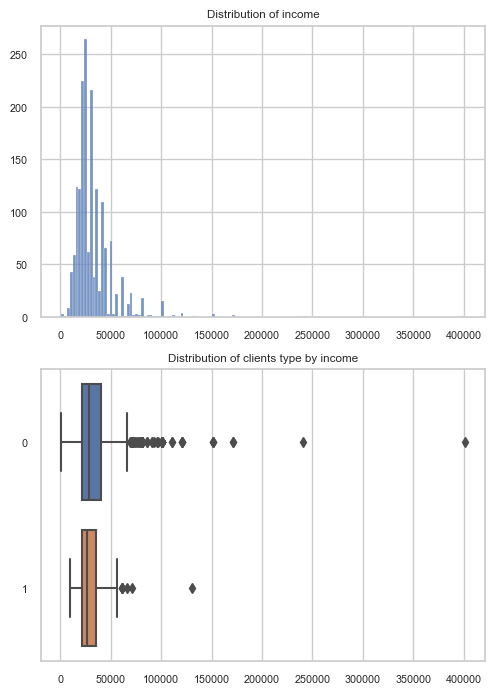

In [25]:
feature = data.columns[9]
feature_description(feature, data)

Analyzed feature:  family_status


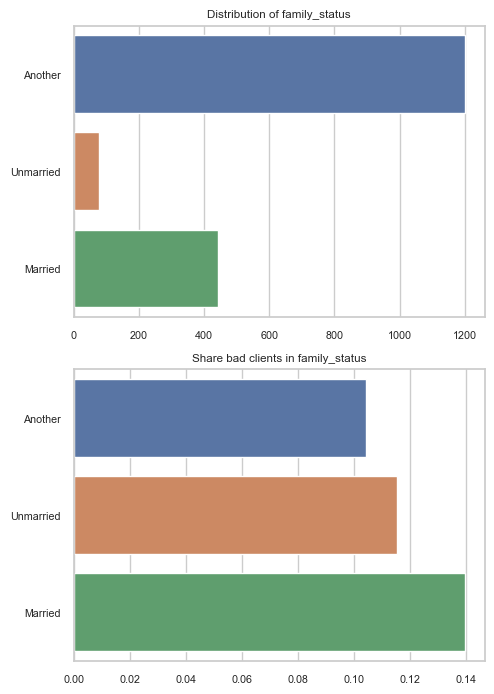

In [26]:
feature = data.columns[10]
feature_description(feature, data)

Analyzed feature:  phone_operator


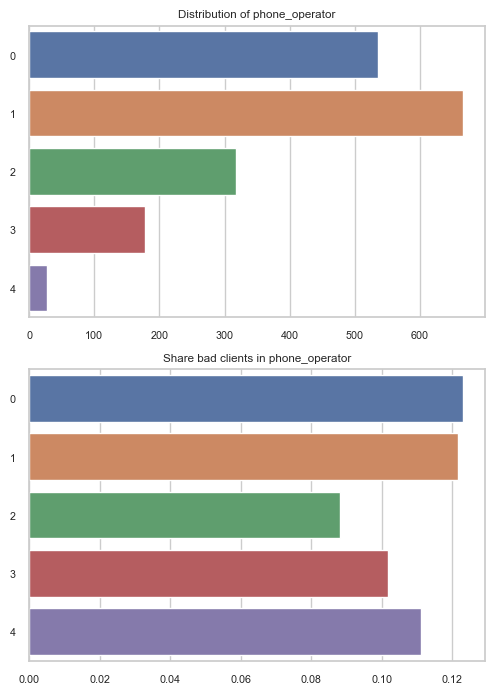

In [27]:
feature = data.columns[11]
feature_description(feature, data)

Analyzed feature:  is_client


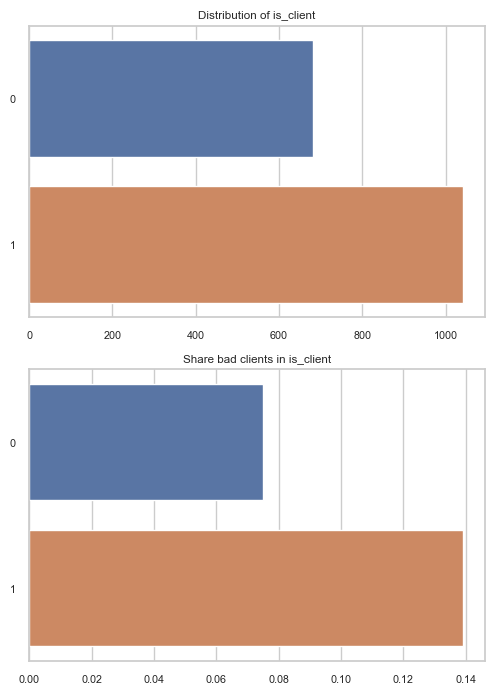

In [28]:
feature = data.columns[12]
feature_description(feature, data)

In [29]:
# Conclusion:

# 1. Most bad clients are in December, minority are in July.
# 2. There are outliers in credit amount.
# 3. Bad clients have higher credit term.
# 4. Female are bad clients more frequently.
# 5. People with only secondary education are bad clients more frequently.
# 6. It seems that loan for cell phone is the most risky
# 7. People with children are less risky clients
# 8. People from region 3 are riskier.
# 9. There are outliers in income.
# 10. Marriage status, phone operator doesn’t influence the probability of client default
# 11. Clients of bank are more risky 


### One-hot-encoding

In [30]:
# OHE
ohe_vars = ['education', 'product_type', 'family_status', 'sex']

print('Before: ',data.shape)
for ohe_var in ohe_vars:
    data = encode_and_bind(data , ohe_var)
    
data = data.drop('sex_male', axis = 1)
data = data.rename(columns = {"product_type_Childen's goods": "product_type_Childen_good"})
print('After: ',data.shape)    

Before:  (1723, 14)
After:  (1723, 42)


In [31]:
# Swap data
data = data[['bad_client_target','month', 'credit_amount', 
      'credit_term', 'age', 'having_children_flg',
       'region', 'income', 'phone_operator', 'is_client', 
       'education_Higher education', 'education_Incomplete higher education',
       'education_Incomplete secondary education', 'education_PhD degree',
       'education_Secondary education',
       'education_Secondary special education', 'product_type_Audio & Video',
       'product_type_Auto', 'product_type_Boats', 'product_type_Cell phones',
       'product_type_Childen_good', 'product_type_Clothing',
       'product_type_Computers', 'product_type_Construction Materials',
       'product_type_Cosmetics and beauty services',
       'product_type_Fishing and hunting supplies', 'product_type_Fitness',
       'product_type_Furniture', 'product_type_Garden equipment',
       'product_type_Household appliances', 'product_type_Jewelry',
       'product_type_Medical services', 'product_type_Music',
       'product_type_Repair Services', 'product_type_Sporting goods',
       'product_type_Tourism', 'product_type_Training',
       'product_type_Windows & Doors', 'family_status_Another',
       'family_status_Married', 'family_status_Unmarried', 'sex_female']]

## Moddelling.

### Train and test split

In [32]:
# split data on target and X
X = data.iloc[:,1:]
y = data.bad_client_target


# split data on train data set
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=5);
print(X_train.shape)
print(X_test.shape)


(1206, 41)
(517, 41)


In [33]:
print('y distribution - train: \n',y_train.value_counts())
print()
print('y distribution - test: \n',y_test.value_counts())

y distribution - train: 
 0    1073
1     133
Name: bad_client_target, dtype: int64

y distribution - test: 
 0    454
1     63
Name: bad_client_target, dtype: int64


In [34]:
# Create result dictionary
res_tab = {}

### Default model

In [35]:
# model name
model_name = 'default_logit'

# 2. Fit model
model = LogisticRegression(random_state=5)
model.fit(X_train,y_train)

# 2. Prediction
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_def = round(auc(fpr, tpr),3)
print('AUC: ', auc_def)

# 3. Prediction + threshold
threshold = 0.1
prediction = np.where(prediction < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

# 4. Save results
res_tab[model_name] = auc_def

AUC:  0.619
confusion_matrix: 
 [[194 260]
 [ 21  42]]


In [36]:
auc(fpr, tpr)

0.618523180197189

### Tunning

#### LogisticRegression

In [37]:
# 1. model_name
model_name = 'logit'

# 2. Determine model
pipeline = make_pipeline(StandardScaler(), 
                           LogisticRegression(random_state=5)
                        )
# 3. Create the parameter grid
param_grid = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__solver': ['liblinear', 'newton-cg', 'saga'],
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab[model_name] = auc_res

GS_best_param:  {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
AUC:  0.74942


C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Roman\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Roman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty,

#### Decision Tree

In [38]:
# 1. model_name
model_name = 'Decision_Tree'

# 2. Determine model
scal = StandardScaler()
method = DecisionTreeClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'decisiontreeclassifier__max_leaf_nodes': list(range(2, 100, 5)),
    'decisiontreeclassifier__min_samples_split': [2, 3, 5,10],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab[model_name] = auc_res

GS_best_param:  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_leaf_nodes': 12, 'decisiontreeclassifier__min_samples_split': 2}
AUC:  0.69077


#### Random Forest

In [39]:
# 1. model_name
model_name = 'Random_forest'

# 2. Determine model
scal = StandardScaler()
method = RandomForestClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'randomforestclassifier__max_depth':[2, 3, 4, 5],
    'randomforestclassifier__max_features':[2, 3, 5],
    'randomforestclassifier__n_estimators':[100, 1000],
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab[model_name] = auc_res

GS_best_param:  {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 3, 'randomforestclassifier__n_estimators': 1000}
AUC:  0.75659


#### SGD

In [40]:
# 1. model_name
model_name = 'SGD'

# 2. Determine model
scal = StandardScaler()
method = SGDClassifier(random_state=5)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'sgdclassifier__alpha':[0.0001, 0.001, 0.1],
    'sgdclassifier__loss':[ 'log'],
    'sgdclassifier__max_iter':[1000, 10000, 1000000]
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab[model_name] = auc_res

GS_best_param:  {'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'log', 'sgdclassifier__max_iter': 1000}
AUC:  0.74649


#### SVM

In [42]:
# 1. model_name
model_name = 'SVM'

# 2. Determine model
scal = StandardScaler()
method = SVC(random_state=5, probability = True)

pipeline = make_pipeline(
                        scal, 
                        method
                        )
# 3. Create the parameter grid
param_grid = [{
    'svc__C':[0.1, 1, 10, 100, 1000],
    'svc__gamma':[1, 0.1, 0.01, 0.001, 0.0001],
}]

# 4. Create an instance of GridSearch Cross-validation estimator
gs = GridSearchCV(estimator=pipeline,
                     param_grid = param_grid,
                     scoring='roc_auc',
                     cv=5,
                     refit = True,
                     n_jobs=1)

# 5. Train the LogisticRegression Classifier
gs_res = gs.fit(X_train, y_train)
print('GS_best_param: ', gs_res.best_params_)

# 6. Quality metric and saving result
model = gs_res.best_estimator_
prediction = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc_res = round(auc(fpr, tpr),5)
print('AUC: ', auc_res)

# 7. Save the result
res_tab[model_name] = auc_res

GS_best_param:  {'svc__C': 100, 'svc__gamma': 0.0001}
AUC:  0.62108


### Result table

In [43]:
(pd.DataFrame.from_dict(res_tab, orient='index')
 .rename(columns = {0:'AUC'})
 .sort_values('AUC', ascending = False)
)

,AUC
Random_forest,0.75659
logit,0.74942
SGD,0.74649
Decision_Tree,0.69077
SVM,0.62108
default_logit,0.61900


In [45]:
# The best mode is Random forest

In [46]:
# 2. Fit model
model = RandomForestClassifier(random_state=5, 
                               max_depth = 4,
                               max_features = 3,
                               n_estimators = 1000
                              )
model.fit(X_train,y_train)

# 2. Prediction
prediction_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob)
auc_def = round(auc(fpr, tpr),3)
print('AUC: ', auc_def)

# 3. Prediction + threshold
threshold = 0.15
prediction = np.where(prediction_prob < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))



AUC:  0.757
confusion_matrix: 
 [[400  54]
 [ 35  28]]


### Feature selection

In [47]:
num_feat_auc = {}
# for i in range(2, X_train.shape[1]):
for i in [5,15,25,35,41]:
    rfe_support, rfe_feature = rfe_selector(X_train, y_train, num_feats=i)
    
    model = RandomForestClassifier(random_state=5, 
                               max_depth = 4,
                               max_features = 3,
                               n_estimators = 1000
                              )
    model.fit(X_train[rfe_feature],y_train)

    # 2. Prediction
    prediction_prob = model.predict_proba(X_test[rfe_feature])[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, prediction_prob)
    auc_def = auc(fpr, tpr)
    
    num_feat_auc[i] = auc_def

,number_features,AUC
0,5,0.741591
1,15,0.752780
2,25,0.757290
3,35,0.757115
4,41,0.757080


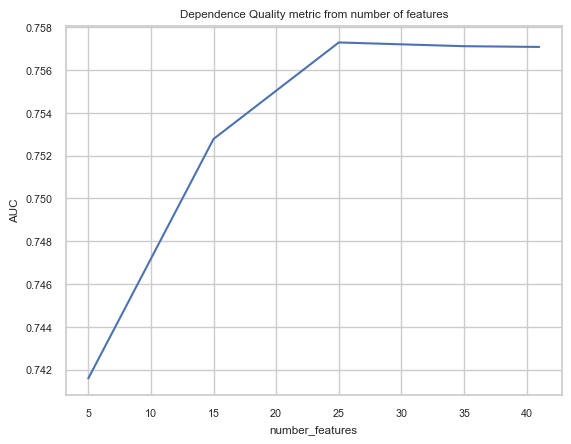

In [48]:
# data for plot
feat_res = \
(pd.DataFrame.from_dict(num_feat_auc, orient='index')
 .rename(columns = {0:'AUC'})
 .reset_index()
 .rename(columns = {'index':'number_features'})
)

# Make plot
title = 'Dependence Quality metric from number of features'
sns.lineplot(feat_res, x = 'number_features', y = 'AUC').set(title=title);

feat_res

In [49]:
# So We can select 5 festures and don't lose the quality in metrics dramatically
num_feat = 15
rfe_support, rfe_feature = rfe_selector(X_train, y_train,num_feat)
print('selected features',rfe_feature)

### Result model

In [50]:
# 2. Fit model
model = RandomForestClassifier(random_state=5, 
                               max_depth = 4,
                               max_features = 3,
                               n_estimators = 1000
                              )
model.fit(X_train[rfe_feature],y_train)

# 2. Prediction
prediction_prob = model.predict_proba(X_test[rfe_feature])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob)
auc_def = round(auc(fpr, tpr),3)
print('AUC: ', auc_def)

# 3. Prediction + threshold
threshold = 0.15
prediction = np.where(prediction_prob < threshold, 0, 1)
print('confusion_matrix: \n',confusion_matrix(y_test, prediction))

AUC:  0.753
confusion_matrix: 
 [[367  87]
 [ 31  32]]


### Threshold analysis

C:\Users\Roman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Roman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Roman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Roman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

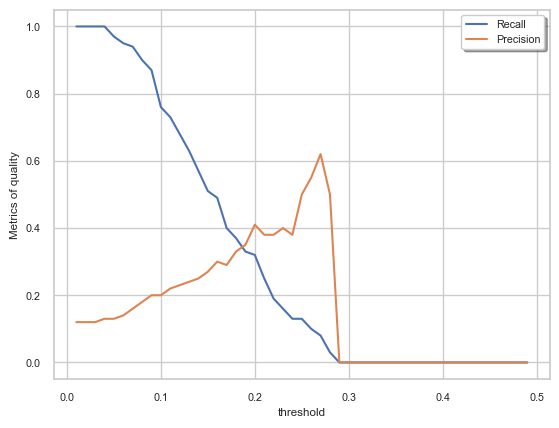

In [52]:
# 1. table with recall / precision
rec_prec_threshold = pd.DataFrame(
    {'threshold':np.arange(0.01, 0.5, 0.01),
     'Recall':np.nan,
     'Precision': np.nan} )

# 2. Main calculation
for i in range(len(rec_prec_threshold)):
    prediction = np.where(prediction_prob < rec_prec_threshold['threshold'][i], 0, 1)
    rec_prec_threshold['Recall'][i]  = round(recall_score(y_pred = prediction, y_true = y_test),2)
    rec_prec_threshold['Precision'][i]  = round(precision_score(y_pred = prediction, y_true = y_test),2)

# 3. Plot it
x = rec_prec_threshold.threshold
y  = rec_prec_threshold.Recall
z = rec_prec_threshold.Precision
plt.plot(x, y);
plt.plot(x, z);
plt.legend(['Recall','Precision' ],shadow = True, loc = 1);
plt.xlabel('threshold')
plt.ylabel('Metrics of quality');

In [ ]:
# To select need threshold we need to find the trade of between Recall and Precision